In [1]:
from train_SimCLR_utils import *
import torch
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
from torchvision import transforms
import random
import numpy as np
from dataset.utils.utils import TextColors as tc
from plot_utils.plot import plot_train_test_losses
from datetime import date, datetime
import torch.nn.functional as F
import cv2
import json

In [2]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

In [3]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", start_string)

Current Date and Time: 2023-12-12 10:04:03


In [4]:
import os
os.getcwd()

NAFISEH = "Nafiseh"
MOIEN = "Moien"

if "d:" in os.getcwd():
    USER = MOIEN
elif "c:" in os.getcwd():
    USER = NAFISEH
else:
    raise Exception("Unknown user")

USER

'Nafiseh'

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# CONFIG
NUM_WORKERS = 6 if USER == NAFISEH else 2
TRAIN_BATCH_SIZE = 32 if USER == NAFISEH else 4
TEST_BATCH_SIZE = 32 if USER == NAFISEH else 4
LEARNING_RATE = 1e-4 if USER == NAFISEH else 1e-4
NUM_EPOCHS = 17 if USER == NAFISEH else 2
LR_SCHEDULER = "step" # step, plateau or None

OC_MAX = 87
USE_SRTM = True

USE_SPATIAL_ATTENTION = False if USER == NAFISEH else False
CNN_ARCHITECTURE = 'ViT' # vgg16 or resnet101 or "ViT"
RNN_ARCHITECTURE = 'LSTM' # LSTM, GRU, RNN, Transformer
REG_VERSION = 1 if USER == NAFISEH else 2
USE_LSTM_BRANCH = True

In [7]:

if USE_SRTM:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = OC_MAX)
else:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = OC_MAX)
    
my_to_tensor = myToTensor()
my_augmentation = Augmentations()
train_transform = transforms.Compose([mynorm, my_to_tensor,my_augmentation])
test_transform = transforms.Compose([mynorm, my_to_tensor])

In [8]:
if USER == MOIEN:
    train_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\train\\'
    test_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\test\\'
    val_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    testval_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    lucas_csv_path = 'D:\python\SoilNet\dataset\LUCAS_2015_all.csv'
    climate_csv_folder_path = "D:\\python\\SoilNet\\dataset\\Climate\\All\\filled\\"
    
elif USER == NAFISEH:
    train_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\train'
    
    test_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\test'
    val_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\val'
    testval_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\test_val'
    # lucas_csv_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\LUCAS_2015_all.csv'
    lucas_csv_path = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\simclr\\simclr.csv" # The LUCAS will be replaced by SimCLR file
    climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\Climate\\All\\filled'

In [9]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11] if not USE_SRTM else [0,1,2,3,4,5,6,7,8,9,10,11,12,13]


################################# IF Not USE_LSTM_BRANCH ###############################
if not USE_LSTM_BRANCH: # NOT USING THE CLIMATE DATA

    train_ds = SNDataset(train_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=train_transform)
    test_ds =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    val_ds = SNDataset(val_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    test_ds_w_id =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    testval_ds_w_id =  SNDataset(testval_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    
################################### IF USE_LSTM_BRANCH #################################
else: # USING THE CLIMATE DATA
    train_ds = SNDatasetClimate(train_l8_folder_path,
                                    lucas_csv_path,
                                    climate_csv_folder_path,
                                    l8_bands=bands, transform=train_transform)

    test_ds = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    val_ds = SNDatasetClimate(val_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    test_ds_w_id = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)

    testval_ds_w_id = SNDatasetClimate(testval_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)
    


In [10]:
SEQ_LEN = testval_ds_w_id[0][0][1].shape[0]
SEQ_LEN # max sequence length for Transformer model set up

61

In [11]:
# COUNTING the csv files in the csv folder
CSV_FILES = [f for f in os.listdir(climate_csv_folder_path) if f.endswith('.csv')]
NUM_CLIMATE_FEATURES = len(CSV_FILES)
NUM_CLIMATE_FEATURES

11

In [12]:
from soilnet.soil_net import SoilNet, SoilNetLSTM, SoilNetSimCLR

__name__: submodules.src.transformer.transformer


In [13]:
# train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# # Get image and label from custom DataLoader
# img_custom, climate,label_custom = next(iter(train_dl))
# print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
# print(f"Climate shape: {climate.shape} -> [batch_size, climate_channels]")
# print(f"Label shape: {label_custom.shape}")
# img_gpu = img_custom.to(device)
# print(img_gpu.device, img_gpu.shape)
# print(img_gpu.shape)
# y = model(img_gpu)
# y.detach()

In [14]:
cv_results = {"train_loss": [],
                "train_acc_top1": [],
                "train_acc_top5": [],
                "train_acc_mean_pos": [],
                "val_loss": [],
                "val_acc_top1": [],
                "val_acc_top5": [],
                "val_acc_mean_pos": [],
    }

In [15]:
from datetime import date, datetime
# Format the date and time
now = datetime.now()
run_name = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Current Date and Time:", run_name)
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

Current Date and Time: D_2023_12_12_T_10_04


In [16]:
# SEEDS = [75] 
SEEDS = [1]  if USER == MOIEN else [1]
# SEEDS = [1] if USER == MOIEN else [1, 4, 69, 75, 79, 128, 474, 786, 2048, 3333]

In [17]:
best_mae = 1000 # just a big number, since our data is normalized between 0 and 1, mae is between 0 and 1 too.
best_seed = SEEDS[0]
for idx, seed in enumerate(SEEDS):
    print(tc.BOLD_BAKGROUNDs.PURPLE, f"CROSS VAL {idx+1}", tc.ENDC)
    
    
    train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    val_dl = DataLoader(val_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    #model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    # architecture = "101+GLAM" if USE_SPATIAL_ATTENTION else "101"
    if USE_LSTM_BRANCH:
        model = SoilNetSimCLR(use_glam=USE_SPATIAL_ATTENTION, cnn_arch= CNN_ARCHITECTURE, reg_version= REG_VERSION,
                           cnn_in_channels=len(bands), regresor_input_from_cnn=128,
                           lstm_n_features= NUM_CLIMATE_FEATURES, lstm_n_layers= 2, lstm_out= 128,
                           hidden_size=128, rnn_arch="Transformer",seq_len=SEQ_LEN).to(device)
    else:
        model = SoilNet(use_glam=USE_SPATIAL_ATTENTION, cnn_arch = CNN_ARCHITECTURE, reg_version= REG_VERSION,
                       cnn_in_channels=len(bands), regresor_input_from_cnn=128, hidden_size=128).to(device)
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Saving the model on the last epoch
    save_model_path = f"results/RUN_{run_name}_{USER}.pth.tar"
    
    results = train(model, train_dl, test_dl, val_dl,
                    torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
                    SimCLR(temperature=0.5), epochs=NUM_EPOCHS, lr_scheduler=LR_SCHEDULER,
                    save_model_path= save_model_path,
                    save_model_if_mae_lower_than= best_mae,
                    )

    
    cv_results['train_loss'].append(results['train_loss'])
    cv_results['train_acc_top1'].append(results['train_acc_top1'])
    cv_results['train_acc_top5'].append(results['train_acc_top5'])
    cv_results['train_acc_mean_pos'].append(results['train_acc_mean_pos'])
    cv_results['val_loss'].append(results['val_loss'])
    cv_results['val_acc_top1'].append(results['val_acc_top1'])
    cv_results['val_acc_top5'].append(results['val_acc_top5'])
    cv_results['val_acc_mean_pos'].append(results['val_acc_mean_pos'])
    

    # if results['MAE'][0] < best_mae:
    #     best_mae = results['MAE'][0]
    #     best_seed = seed
    #     print(tc.BOLD_BAKGROUNDs.GREEN, f"MAE improved to {best_mae}", tc.ENDC)
    
        

 CROSS VAL 1 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 656/656 [01:36<00:00,  6.79it/s, Train_Loss=3.56]


 Epoch 1 Results: |  train_loss: 3.5643597292463953 |  val_loss: 3.21548946154172  train_acc_top1: 0.042863948179817785 |  val_acc_top1: 0.09316903135003564  train_acc_top5: 0.24174447412171016 |  val_acc_top5: 0.39278579601958463  train_acc_mean_pos: 16.686132812645376 |  val_acc_mean_pos: 9.752629648060559  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.16it/s, Train_Loss=3.13]


 Epoch 2 Results: |  train_loss: 3.1270816526034984 |  val_loss: 3.0212904503356377  train_acc_top1: 0.1131288110301262 |  val_acc_top1: 0.16343566543979732  train_acc_top5: 0.4674066311520774 |  val_acc_top5: 0.5645792565933646  train_acc_mean_pos: 8.29304973308633 |  val_acc_mean_pos: 6.77666340571016  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.17it/s, Train_Loss=3.03]


 Epoch 3 Results: |  train_loss: 3.033449065576239 |  val_loss: 3.04715846662652  train_acc_top1: 0.15505907012195122 |  val_acc_top1: 0.13477454337899544  train_acc_top5: 0.5490139100428034 |  val_acc_top5: 0.5230247065356878  train_acc_mean_pos: 6.923804306402439 |  val_acc_mean_pos: 7.105257256390297  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 656/656 [01:30<00:00,  7.21it/s, Train_Loss=2.97]


 Epoch 4 Results: |  train_loss: 2.9714767487674223 |  val_loss: 2.997639369746866  train_acc_top1: 0.18488471800597703 |  val_acc_top1: 0.1536916993116135  train_acc_top5: 0.5996046112623157 |  val_acc_top5: 0.5937500002721673  train_acc_mean_pos: 6.07266101386489 |  val_acc_mean_pos: 6.249459802287898  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.21it/s, Train_Loss=2.93]


 Epoch 5 Results: |  train_loss: 2.934532186970478 |  val_loss: 2.903481986424694  train_acc_top1: 0.2134765625090861 |  val_acc_top1: 0.2572060502283105  train_acc_top5: 0.6398675686157331 |  val_acc_top5: 0.6822610894838969  train_acc_mean_pos: 5.574199695412705 |  val_acc_mean_pos: 5.053275848632534  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.20it/s, Train_Loss=2.92]


 Epoch 6 Results: |  train_loss: 2.916083248104991 |  val_loss: 2.8799045608468252  train_acc_top1: 0.22731516773744329 |  val_acc_top1: 0.28918990547254203  train_acc_top5: 0.6611804496951219 |  val_acc_top5: 0.7205744456482804  train_acc_mean_pos: 5.313814786512677 |  val_acc_mean_pos: 4.653375734477283  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.19it/s, Train_Loss=2.89]


 Epoch 7 Results: |  train_loss: 2.890364719418491 |  val_loss: 2.8800395503980383  train_acc_top1: 0.24410727901793108 |  val_acc_top1: 0.25094789634012193  train_acc_top5: 0.6976657774208522 |  val_acc_top5: 0.7141328279830549  train_acc_mean_pos: 4.883017340084401 |  val_acc_mean_pos: 4.654007665642864  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 656/656 [01:28<00:00,  7.39it/s, Train_Loss=2.87]


 Epoch 8 Results: |  train_loss: 2.874438924215189 |  val_loss: 2.8635026711851492  train_acc_top1: 0.26819264479890104 |  val_acc_top1: 0.27972113514599733  train_acc_top5: 0.7148913871951219 |  val_acc_top5: 0.7274237607167736  train_acc_mean_pos: 4.672703887267811 |  val_acc_mean_pos: 4.489369292237443  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 656/656 [01:28<00:00,  7.41it/s, Train_Loss=2.86]


 Epoch 9 Results: |  train_loss: 2.8565653789697625 |  val_loss: 2.8374870465770705  train_acc_top1: 0.28285537351195406 |  val_acc_top1: 0.31130748551730153  train_acc_top5: 0.7342320884146342 |  val_acc_top5: 0.7596726191642622  train_acc_mean_pos: 4.468468940839535 |  val_acc_mean_pos: 4.163313356164384  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 656/656 [01:30<00:00,  7.23it/s, Train_Loss=2.85]


 Epoch 10 Results: |  train_loss: 2.8457371607059385 |  val_loss: 2.8251140868827087  train_acc_top1: 0.2913395579359153 |  val_acc_top1: 0.3273401826484018  train_acc_top5: 0.7463033536403645 |  val_acc_top5: 0.765094993593486  train_acc_mean_pos: 4.332178925595632 |  val_acc_mean_pos: 4.131084883049743  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.21it/s, Train_Loss=2.78]


 Epoch 11 Results: |  train_loss: 2.7841737995423923 |  val_loss: 2.7856208853525657  train_acc_top1: 0.3635908917682927 |  val_acc_top1: 0.3688743477814818  train_acc_top5: 0.8012052210184132 |  val_acc_top5: 0.801594096776013  train_acc_mean_pos: 3.686818787964379 |  val_acc_mean_pos: 3.6418277074212897  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.20it/s, Train_Loss=2.77]


 Epoch 12 Results: |  train_loss: 2.771230638390634 |  val_loss: 2.7770866465895145  train_acc_top1: 0.3768245045822568 |  val_acc_top1: 0.3796579420022224  train_acc_top5: 0.8113900533900028 |  val_acc_top5: 0.8132032781975455  train_acc_mean_pos: 3.537604801901957 |  val_acc_mean_pos: 3.5343484998293664  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.16it/s, Train_Loss=2.76]


 Epoch 13 Results: |  train_loss: 2.7639178871745016 |  val_loss: 2.7646983137958125  train_acc_top1: 0.38513243143878334 |  val_acc_top1: 0.40058300729211604  train_acc_top5: 0.818383193597561 |  val_acc_top5: 0.8224070453208331  train_acc_mean_pos: 3.4661918827673284 |  val_acc_mean_pos: 3.408298679682762  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.18it/s, Train_Loss=2.76]


 Epoch 14 Results: |  train_loss: 2.7554237698999846 |  val_loss: 2.7830968697865806  train_acc_top1: 0.3914729420822568 |  val_acc_top1: 0.360587899543379  train_acc_top5: 0.824194931402439 |  val_acc_top5: 0.8059666505142978  train_acc_mean_pos: 3.409403582171696 |  val_acc_mean_pos: 3.635671478428253  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.19it/s, Train_Loss=2.75]


 Epoch 15 Results: |  train_loss: 2.7544716498473796 |  val_loss: 2.746490622219974  train_acc_top1: 0.3911108994265882 |  val_acc_top1: 0.42162018932708323  train_acc_top5: 0.8239805640243902 |  val_acc_top5: 0.8418847850468605  train_acc_mean_pos: 3.3969035824624503 |  val_acc_mean_pos: 3.2232958258014834  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.19it/s, Train_Loss=2.75]


 Epoch 16 Results: |  train_loss: 2.7452129330940362 |  val_loss: 2.7520238460471096  train_acc_top1: 0.4039681783718307 |  val_acc_top1: 0.4000326158249215  train_acc_top5: 0.833984375 |  val_acc_top5: 0.8356775932660386  train_acc_mean_pos: 3.3149294969512195 |  val_acc_mean_pos: 3.2913201236289384  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 656/656 [01:31<00:00,  7.19it/s, Train_Loss=2.74]


 Epoch 17 Results: |  train_loss: 2.7419850628187015 |  val_loss: 2.763474116042324  train_acc_top1: 0.4045541158354864 |  val_acc_top1: 0.3906657698491937  train_acc_top5: 0.8380811737804879 |  val_acc_top5: 0.8224987771413098  train_acc_mean_pos: 3.2648246951582953 |  val_acc_mean_pos: 3.445704908675799  

Adjusting learning rate of group 0 to 2.0000e-05.


In [ ]:
torch.save(model, f"results/RUN_{run_name}_{USER}_SelfSupervised.pth")

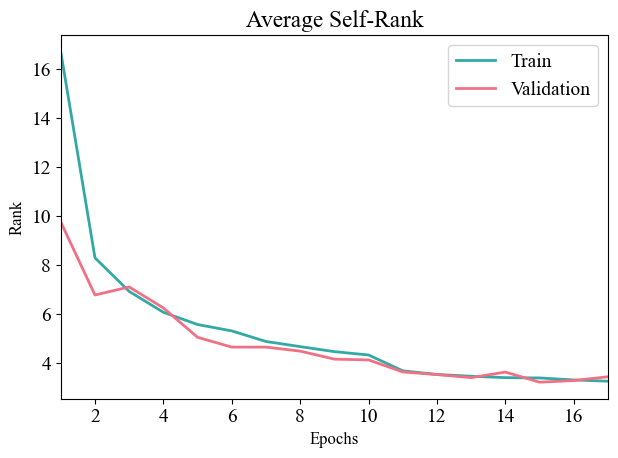

In [18]:
train_arr = np.asarray(cv_results['train_acc_mean_pos'])
val_arr = np.asarray(cv_results['val_acc_mean_pos'])
train_arr.shape, val_arr.shape
plot_train_test_losses(train_arr,val_arr, title="Average Self-Rank", x_label="Epochs", y_label="Rank",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{run_name}_{USER}.png")

In [ ]:
model = torch.load(f"results/RUN_{run_name}_{USER}_SelfSupervised.pth")

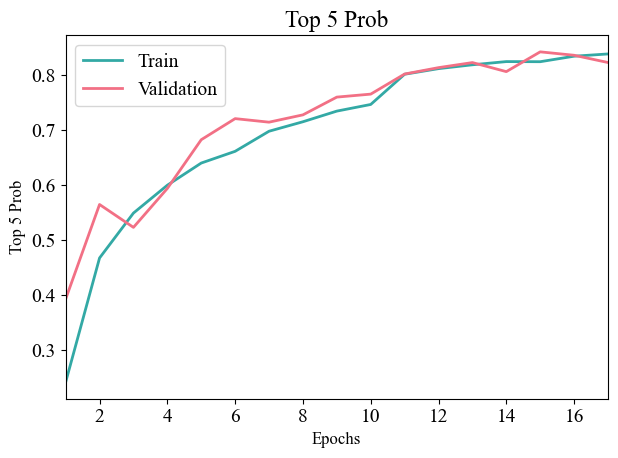

In [19]:
train_arr = np.asarray(cv_results['train_acc_top5'])
val_arr = np.asarray(cv_results['val_acc_top5'])
train_arr.shape, val_arr.shape
plot_train_test_losses(train_arr,val_arr, title="Top 5 Prob", x_label="Epochs", y_label="Top 5 Prob",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{run_name}_{USER}.png")

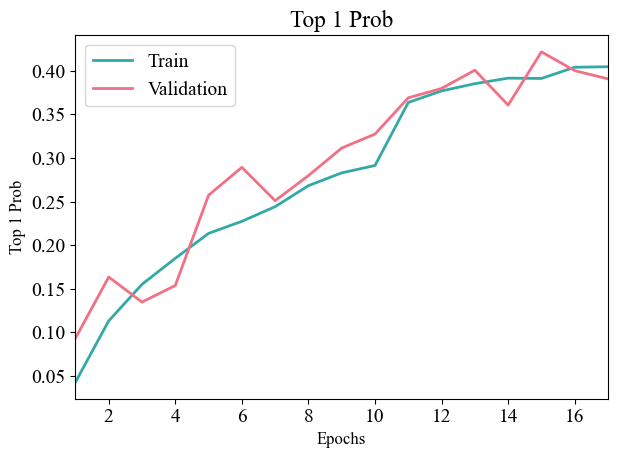

In [20]:
train_arr = np.asarray(cv_results['train_acc_top1'])
val_arr = np.asarray(cv_results['val_acc_top1'])
train_arr.shape, val_arr.shape
plot_train_test_losses(train_arr,val_arr, title="Top 1 Prob", x_label="Epochs", y_label="Top 1 Prob",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{run_name}_{USER}.png")

# END
We change the rest if the code worked on full dataset.

In [ ]:
import csv

In [ ]:
# Format the date and time
now = datetime.now()
finish_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", finish_string)

In [ ]:
cv_results["MAE"],cv_results['RMSE'],cv_results["R2"]

In [ ]:
cv_results_full = {}
cv_results_full['MAE_MEAN'] = np.mean(cv_results['MAE'])
cv_results_full['RMSE_MEAN'] = np.mean(cv_results['RMSE'])
cv_results_full['R2_MEAN'] = np.mean(cv_results['R2'])
cv_results_full['MAE_MEAN'],cv_results_full['RMSE_MEAN'],cv_results_full['R2_MEAN']

In [ ]:
cv_results_full['USE_LSTM_BRANCH'] = USE_LSTM_BRANCH
cv_results_full['NUM_CLIMATE_FEATURES'] = NUM_CLIMATE_FEATURES if USE_LSTM_BRANCH else None
cv_results_full['CSV_FILES'] = CSV_FILES if USE_LSTM_BRANCH else None
cv_results_full['NUM_WORKERS'] = NUM_WORKERS
cv_results_full['TRAIN_BATCH_SIZE'] = TRAIN_BATCH_SIZE
cv_results_full['TEST_BATCH_SIZE'] = TEST_BATCH_SIZE
cv_results_full['LEARNING_RATE'] = LEARNING_RATE
cv_results_full['NUM_EPOCHS'] = NUM_EPOCHS
cv_results_full['LR_SCHEDULER'] = LR_SCHEDULER
cv_results_full['CNN_ARCHITECTURE'] = CNN_ARCHITECTURE
cv_results_full['REG_VERSION'] = REG_VERSION
cv_results_full['USE_SPATIAL_ATTENTION'] = USE_SPATIAL_ATTENTION
cv_results_full['Best Seed'] = best_seed
cv_results_full['SEEDS'] = SEEDS
cv_results_full['OC_MAX'] = OC_MAX
cv_results_full['USE_SRTM'] = USE_SRTM
cv_results_full['TIME'] = {"start": start_string, "finish": finish_string}
cv_results_full['cv_results'] = cv_results

In [ ]:
with open(f"results/RUN_{run_name}_{USER}.json", "w") as fp:
    json.dump(cv_results_full, fp, indent=4)

In [ ]:
# READ JSON FILE
# with open("results/my_dict.json", "r") as fp:
#     my_dict = json.load(fp)

# print(my_dict)

# Analysis

## Save Outputs

### Loading the Best Model
Loading the best model from all the coross validation runs.

In [ ]:
load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),filename=f"results/RUN_{run_name}_{USER}.pth.tar")
model.eval()
print("Model loaded")

load saved model

In [ ]:
# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_05_T_16_02_Nafiseh.pth.tar') #LSTM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_03_T_09_41_Nafiseh.pth.tar') #GLAM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_02_T_20_57_Nafiseh.pth.tar') #Base

# model.eval()
# print("Model loaded")

In [ ]:
test_dl_w_id = DataLoader(test_ds_w_id, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/RUN_{run_name}_{USER}.csv")
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/onlytest_{run_name}_{USER}.csv")

## Visualize Spatial Attention

In [ ]:
if not USE_SPATIAL_ATTENTION or USE_LSTM_BRANCH:
    raise Exception("The Next Part of the Notebook is only available for the model with Spatial Attention and no LSTM Branch")

In [ ]:
BATCH_N = 1

IMG_IN_BATCH = 2

In [ ]:
batch_loader = BatchLoader(test_dl_w_id)

In [ ]:
batch = batch_loader(BATCH_N)
batch[0].shape, batch[1].shape, len(batch[2])

In [ ]:
import sys
import importlib
importlib.reload(sys.modules['plot_utils'])

In [ ]:
from plot_utils.plot import *
from PIL import Image

In [ ]:
# check if results/attention_maps folder exists if not create it
if not os.path.exists("results/attention_maps"):
    os.makedirs("results/attention_maps")

In [ ]:
ABS_ATT = False
ALPHA = 0.4
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.local_spatial_att.att_map.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.local_spatial_att.att_map
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[0]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Local Attention Map Visualization | Point ID: {pid}", figsize=(10,5))
    

    
    
    cv2.imwrite(f"results/attention_maps/final/_{run_name}_{USER}_pid{pid}_img_lcl_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    

In [ ]:
GLOB_ATT_CHANNEL = 510 # ranges between 0 and 511
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.global_spatial_att.att.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.global_spatial_att.att
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[GLOB_ATT_CHANNEL]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Global{GLOB_ATT_CHANNEL} Attention Map Visualization | Point ID: {pid}") 
                #    figsize=(10,5), savepath=f"results/attention_maps/final/RUN_{run_name}_{USER}_pid{pid}_glb{GLOB_ATT_CHANNEL}.png")
    
    # # Save img_rgband img_colormaped as jpg files
    # cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_rgb.png", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    